In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn.functional as F
from torch import nn, optim

from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import MultiStepLR

In [2]:
import sys
sys.path.append("./../../")

from config_reader import ConfigReader
from modules.dvae.model import DVAE
from modules.transformer_gen.ar_cond_2stream.generator import LatentGenerator
from datasets.mnist_loader import MNISTData
from notebooks.utils import show
from modules.common_utils import latent_to_img
from utilities.md_mnist_utils import LabelsInfo

In [3]:
config_path = '/u/82/sukhoba1/unix/Desktop/TA-VQVAE/configs/trArC2s_mnistmd_v256_ds2_nb12_cnb6_remote.yaml'
CONFIG = ConfigReader(config_path=config_path)
CONFIG.print_config_info()

BATCH_SIZE                              12                                      
DEVICE                                  cuda                                    
LR                                      0.001                                   
LR_gamma                                0.1                                     
NUM_EPOCHS                              20                                      
cond_num_blocks                         6                                       
cond_seq_size                           12                                      
cond_vocab_size                         20                                      
config_path                             /u/82/sukhoba1/unix/Desktop/TA-VQVAE/configs/trArC2s_mnistmd_v256_ds2_nb12_cnb6_remote.yaml
dropout_prob                            0.1                                     
hidden_dim                              256                                     
hidden_height                           32                

In [4]:
data_source = MNISTData(
    img_type=CONFIG.mnist_type,
    root_path=CONFIG.root_img_path,
    batch_size=CONFIG.BATCH_SIZE)
train_loader = data_source.get_train_loader(batch_size=8)

In [5]:
dvae = DVAE(
    in_channels=CONFIG.in_channels,
    vocab_size=CONFIG.vocab_size,
    num_x2downsamples=CONFIG.num_x2downsamples,
    num_resids_downsample=CONFIG.num_resids_downsample,
    num_resids_bottleneck=CONFIG.num_resids_bottleneck,
    hidden_dim=CONFIG.hidden_dim,
    device=CONFIG.DEVICE)

# G = LatentGenerator(
#     hidden_width=CONFIG.hidden_width,
#     hidden_height=CONFIG.hidden_height,
#     embedding_dim=CONFIG.vocab_size,
#     num_blocks=CONFIG.num_blocks,
#     cond_num_blocks=CONFIG.cond_num_blocks,
#     cond_seq_size=CONFIG.cond_seq_size,
#     cond_vocab_size=CONFIG.cond_vocab_size,
#     hidden_dim=CONFIG.hidden_dim,
#     n_attn_heads=CONFIG.n_attn_heads,
#     dropout_prob=CONFIG.dropout_prob,
#     device=CONFIG.DEVICE)

dvae.eval()
# G.eval()

dvae.load_model(
    root_path=CONFIG.vae_model_path,
    model_name=CONFIG.vae_model_name)

# G.load_model(CONFIG.model_path, CONFIG.model_name)

pass

In [8]:
description = [
    ['8', '30', 'r', 'up', '3', '20', 'g', 'up', '2', '20', 'w', 'middle'],
    ['5', '30', 'g', 'middle', '2', '30', 'w', 'down', '4', '20', 'w', 'down'],
    ['5', '40', 'r', 'down', '3', '30', 'w', 'middle', '0', '40', 'b', 'down'],
    ['8', '20', 'g', 'down', '7', '40', 'w', 'middle', '2', '20', 'w', 'middle'],
    ['9', '30', 'r', 'middle', '2', '30', 'w', 'down', '2', '40', 'r', 'down'],
    ['5', '30', 'g', 'up', '2', '40', 'g', 'up', '6', '40', 'w', 'down'],
    ['8', '30', 'g', 'middle', '4', '30', 'b', 'middle', '0', '40', 'r', 'up'],
    ['6', '30', 'b', 'down', '4', '20', 'b', 'middle', '1', '20', 'g', 'down']
]

json_path = '/m/home/home8/82/sukhoba1/data/Desktop/TA-VQVAE/data/multi_descriptive_MNIST/description/labels_info.json'
li = LabelsInfo(json_path)

description_ids = li.encode_values(description)

description_tensor = torch.LongTensor(description_ids).T.to(CONFIG.DEVICE)

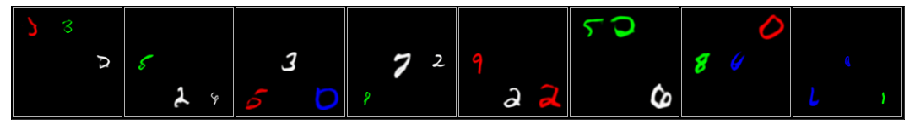

In [13]:
with torch.no_grad():
    gen_lat = G.sample(description_tensor)

gen_img = latent_to_img(gen_lat, dvae, CONFIG.hidden_height, CONFIG.hidden_width)

show(gen_img, figsize=(16,16), plot_grid=True)